In [1]:
import os

from models.vae import DenseVariationalAutoencoder
from models.utils.loaders import load_mnist
import pandas as pd
import numpy as np
from tensorflow.python.framework.ops import disable_eager_execution
from matplotlib import pyplot as plt

disable_eager_execution()

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

N_DENSE = 1
L=8
TRAINING_FRACTION = 0.8
NON_LINEAR_ACTIVATION_BOOL=False

In [2]:
user = 1
if user == 1:
    prefix_s3 = "/home/owen/"
    prefix_data = "/home/owen/repos/"
elif user == 2:
    prefix_data = "/Users/omyers/repos/"

In [3]:
# run params
SECTION = 'vae'
RUN_ID = '0003'
#DATA_NAME = 'digits'
DATA_NAME = 'ising'
RUN_FOLDER = '{}/run/{}/'.format(os.getcwd(), SECTION)
RUN_FOLDER += '_'.join([RUN_ID, DATA_NAME])

if not os.path.exists(RUN_FOLDER):
    os.makedirs(RUN_FOLDER)
    os.mkdir(os.path.join(RUN_FOLDER, 'viz'))
    os.mkdir(os.path.join(RUN_FOLDER, 'images'))
    os.mkdir(os.path.join(RUN_FOLDER, 'weights'))

mode =  'build' #'load' #


In [4]:
df_bins = pd.read_csv("{prefix_data}z3support/data/SpinMLData/2DIsing/L-{L}/L-{L}-T-1-5/bins_L-{L}-T-1-5.txt".format(L=L,prefix_data=prefix_data), sep="\t")
df_conf = pd.read_csv("{prefix_data}z3support/data/SpinMLData/2DIsing/L-{L}/L-{L}-T-1-5/spinConfigs_L-{L}-T-1-5.txt".format(L=L,prefix_data=prefix_data), delimiter=r"\s+", header=None)

In [5]:
df_bins = df_bins[df_bins[' T '] != ' T ']

In [6]:
df_bins = df_bins.astype(
    {
        " T ": int,
        " binNum": int,
    }
)

## Get the temp and magnatization into the configuration dataframe

In [7]:
df_conf["T"] = df_bins[" T "]

In [8]:
mean_col = df_conf[0].copy()
for i in range(1, L):
    mean_col += df_conf[i]

mean_col /= L

In [9]:
df_conf["M"] = mean_col

In [10]:
filterned_confs = df_conf
#filterned_confs = df_conf[(df_conf["T"] < 1.5) | (df_conf["T"] > 4.5)]

In [11]:
filterned_confs.head()

,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,63,T,M
0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,1.0,-1.0
1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,1.0,-1.0
2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,1.0,-1.0
3,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,1.0,-1.0
4,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,1.0,-1.0


We need the data in the format: `(x_train, y_train), (x_test, y_test)`

In [12]:
train_with_meta_info = filterned_confs.sample(frac=TRAINING_FRACTION, axis=0)
test_with_meta_info = filterned_confs.drop(index=train_with_meta_info.index)

In [13]:
train = train_with_meta_info.drop(["T","M"], axis=1)
test = test_with_meta_info.drop(["T","M"], axis=1)

# Check what MNIST data looked like

In [14]:
(x_train, y_train), (x_test, y_test) = load_mnist()

In [15]:
np.shape(x_train)

(60000, 28, 28, 1)

In [16]:
np.shape(x_train)

(60000, 28, 28, 1)

## Make our data the same

In [17]:
train.to_numpy().shape

(4000, 64)

In [18]:
x = train.to_numpy().reshape(-1,L*L)
x_test = test.to_numpy().reshape(-1,L*L)

In [19]:
np.array([[1,1,1,1], [2,2,3,3], [4,4,5,5]]).reshape(-1,2)

array([[1, 1],
       [1, 1],
       [2, 2],
       [3, 3],
       [4, 4],
       [5, 5]])

In [20]:
x = x.astype(float)

In [21]:
x.shape

(4000, 64)

## Run VAE

In [22]:
vae = DenseVariationalAutoencoder(
    input_dim=(L*L,),
    encoder_layer_sizes=[2],
    decoder_layer_sizes=[2, L*L],
    z_dim=N_DENSE,
    non_linear_activation_bool=NON_LINEAR_ACTIVATION_BOOL
)

In [23]:
LEARNING_RATE = 0.0005
#R_LOSS_FACTOR = 1000
R_LOSS_FACTOR = 100

In [24]:
BATCH_SIZE = 16
EPOCHS = 500
PRINT_EVERY_N_BATCHES = 100
INITIAL_EPOCH = 0

In [25]:
#len(x_test)
test_with_meta_info = test_with_meta_info.reset_index()

In [26]:
from sqlalchemy import create_engine
engine = create_engine('sqlite://', echo=False)

In [27]:
magnitization_for_plot = None
t = None
list_of_latent_param_results = []

n_runs = 5

color_list = [ '#326496', '#969696', '#649664', '#c8c896', '#fafac8', '#c8fafa', '#646496', '#c8c8fa', '#9696c8', '#c8fac8', ] 

r_loss_list = [1, 10, 100, 1000, 10000]

In [28]:
for i in range(n_runs):
    vae.compile(LEARNING_RATE, r_loss_list[i])
    vae.train(     
        x,
        batch_size = BATCH_SIZE,
        epochs = EPOCHS,
        run_folder = RUN_FOLDER,
        print_every_n_batches = PRINT_EVERY_N_BATCHES,
        initial_epoch = INITIAL_EPOCH,
    )
    z_points = vae.encoder.predict(x_test)
    test_with_meta_info["latent_1"] = z_points[:, 0]
    test_with_meta_info.to_sql('filtered_confs', con=engine, if_exists='replace')
    avg_m_out = engine.execute(
    """
        select 
            t,
            avg(abs(m)),
            avg(abs(latent_1))
        from filtered_confs
        group by t
    """).fetchall()
    
    if i == 0:
        magnitization_for_plot = [i[1] for i in avg_m_out[0:]]
        t = [i[0] for i in avg_m_out[0:]]
        
    list_of_latent_param_results.append([i[2] for i in avg_m_out[0:]])

Train on 4000 samples
Epoch 1/500


2022-06-17 08:13:24.677829: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-06-17 08:13:24.677852: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: owen-PRIME-Z390-A
2022-06-17 08:13:24.677856: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: owen-PRIME-Z390-A
2022-06-17 08:13:24.677917: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.129.6
2022-06-17 08:13:24.677932: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.129.6
2022-06-17 08:13:24.677936: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 470.129.6
2022-06-17 08:13:24.678573: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following

4000/4000 [==============================] - 0s 57us/sample - loss: 1.7159 - vae_r_loss: 1.2518 - vae_kl_loss: 0.4641
Epoch 2/500
4000/4000 [==============================] - 0s 33us/sample - loss: 1.3959 - vae_r_loss: 1.2084 - vae_kl_loss: 0.1876
Epoch 3/500
4000/4000 [==============================] - 0s 34us/sample - loss: 1.2576 - vae_r_loss: 1.1561 - vae_kl_loss: 0.1015
Epoch 4/500
4000/4000 [==============================] - 0s 32us/sample - loss: 1.1676 - vae_r_loss: 1.1052 - vae_kl_loss: 0.0625
Epoch 5/500
4000/4000 [==============================] - 0s 35us/sample - loss: 1.1081 - vae_r_loss: 1.0665 - vae_kl_loss: 0.0416
Epoch 6/500
4000/4000 [==============================] - 0s 33us/sample - loss: 1.0651 - vae_r_loss: 1.0371 - vae_kl_loss: 0.0280
Epoch 7/500
4000/4000 [==============================] - 0s 34us/sample - loss: 1.0453 - vae_r_loss: 1.0259 - vae_kl_loss: 0.0194
Epoch 8/500
4000/4000 [==============================] - 0s 34us/sample - loss: 1.0320 - vae_r_loss: 1

/home/owen/repos/z3support/pythonenv/lib/python3.8/site-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Train on 4000 samples
Epoch 1/500
4000/4000 [==============================] - 0s 46us/sample - loss: 10.0000 - vae_r_loss: 10.0000 - vae_kl_loss: 1.1885e-06
Epoch 2/500
4000/4000 [==============================] - 0s 39us/sample - loss: 10.0000 - vae_r_loss: 10.0000 - vae_kl_loss: 5.5422e-07
Epoch 3/500
4000/4000 [==============================] - 0s 40us/sample - loss: 10.0000 - vae_r_loss: 10.0000 - vae_kl_loss: 8.7019e-06
Epoch 4/500
4000/4000 [==============================] - 0s 42us/sample - loss: 10.0000 - vae_r_loss: 10.0000 - vae_kl_loss: 2.6673e-09
Epoch 5/500
4000/4000 [==============================] - 0s 41us/sample - loss: 10.0000 - vae_r_loss: 10.0000 - vae_kl_loss: 5.2974e-09
Epoch 6/500
4000/4000 [==============================] - 0s 39us/sample - loss: 10.0000 - vae_r_loss: 10.0000 - vae_kl_loss: 1.9729e-08
Epoch 7/500
4000/4000 [==============================] - 0s 33us/sample - loss: 10.0000 - vae_r_loss: 10.0000 - vae_kl_loss: 6.6414e-08
Epoch 8/500
4000/4000 [===

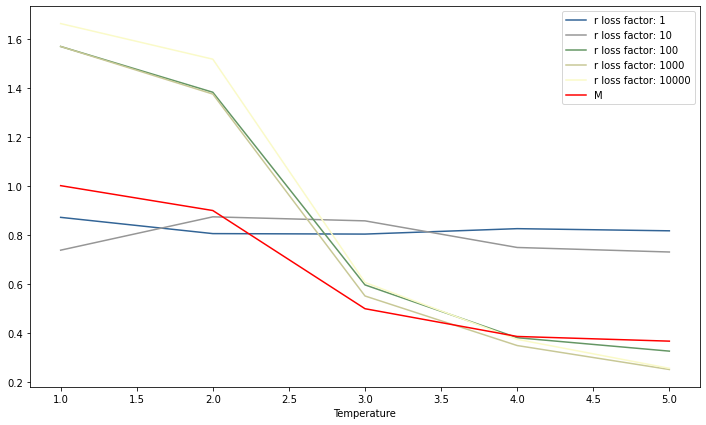

In [30]:
fig, axes= plt.subplots(nrows=1, ncols=1,figsize=(12,7))
for i in range(n_runs):
    plt.plot(t, list_of_latent_param_results[i], c=color_list[i], label="r loss factor: {}".format(r_loss_list[i]))
    
plt.plot(t, magnitization_for_plot, c='r', label='M')
plt.xlabel("Temperature")
plt.legend()
plt.savefig("{}/s3-bucket/reproduction/fig_2/vae_dense_magnitization_and_latent_param_vs_temp_r_loss_sweeps_l{}_epochs_{}.png".format(prefix_s3, L, EPOCHS))